# Extended Kalman Filter

Kevin Walchko

---

## References

- Martin Pettersson, "Extended Kalman Filter for Robust UAV Attitude Estimation," Linkopings Universitet, Dept of EE, 2015.
- D. Titterton, J.L. Weston, and Institution of Electrical Engineers. "Strapdown Inertial Navigation Technology," 2nd Edition. IEE radar, sonar, navigation, and avionics series. Institution of Engineering and Technology, 2004. ISBN 9780863413582.

## Quaternions and Orientation

I am using Hamilton quaternions which track a rotating body's orientation relative to a fixed global frame.

$$
q = \begin{bmatrix} w & x & y & z \end{bmatrix} \\
q = \begin{bmatrix} q_0 & q_1 & q_2 & q_3 \end{bmatrix} \\
q^* = \begin{bmatrix} w & -x & -y & -z \end{bmatrix}
$$

where $q$ describes the quaternion and $q^*$ describes the conjugate of the quaternion.

Rotating vectors from body frame ($x^b$) to a global navigation frame ($x^n$) is given by:

$$
x^n = q \otimes x^b \otimes q^* \\
x^b = q^* \otimes x^n \otimes q
$$

Updating the orientation of the rotating body from angular rates ($\omega_x$, $\omega_y$, $\omega_z$) is given by:

$$
\dot q = \frac{1}{2} q \otimes w \\
w = \begin{bmatrix} 0 & \omega_x & \omega_y & \omega_z \end{bmatrix} \\
q_{k+1} = q_k + \frac{1}{2} q_k \otimes w_k \Delta t
$$

## Euler

Quaternion to Euler angles from Titterton:

$$
\phi = \arctan \left[ \frac {2(q_2q_3+q_0q_1)} {1 - 2(q_1^2 + q_2^2)} \right] \\
\theta = \arcsin (2(q_0q_2-q_1q_3)) \\
\psi = \arctan \left[ \frac {2(q_1q_2+q_0q_3)} {1 - 2(q_2^2 + q_3^2)} \right] \\
$$

with non-linearity around pitch $\pm90^\circ$.

## Reference Frames

- Body (b): x(forward), y(right), z(down), origin fixed at CM
- NED (n): x(North), y(East), z(Down), origin fixed at arbitrary location

## EKF Equations

The equations of motion are:

$$
\dot p^n = v^n \\
\dot v^n = R^n_b a^b_{imu} - g^n \\
g^n = \begin{bmatrix} 0 & 0 & g \end{bmatrix}^T
$$

where the rotation matrix comes from $q$ which is the output of a complementary filter using the accelerameters and gyros.

The inputs to the EKF are:

- Altitude derived from the pressure sensor


## Earth's Magnetic Field

Magnetic info from [NOAA][1]

```json
{
  "result": [
    {
      "date": 2023.19178,
      "totalintensity_uncertainty": 145,
      "horintensity": 23273.4,
      "latitude": 34.08,
      "zcomponent": 42040.7,
      "horintensity_uncertainty": 128,
      "ycomponent_uncertainty": 94,
      "inclination_uncertainty": 0.21,
      "declination_sv": -0.1045,
      "totalintensity": 48052.8,
      "longitude": -106.65,
      "elevation": 1.1,
      "inclination": 61.03138,
      "ycomponent": 3209.7,
      "totalintensity_sv": -105.4,
      "declination_uncertainty": 0.35,
      "zcomponent_sv": -103.1,
      "declination": 7.92706,
      "ycomponent_sv": -46.3,
      "xcomponent_uncertainty": 131,
      "xcomponent_sv": -25.1,
      "xcomponent": 23051,
      "inclination_sv": -0.027,
      "zcomponent_uncertainty": 157,
      "horintensity_sv": -31.2
    }
  ],
  "model": "WMM-2020",
  "units": {
    "inclination": "degrees",
    "totalintensity_uncertainty": "nanoTesla (nT)",
    "elevation": "km",
    "ycomponent": "nanoTesla (nT)",
    "totalintensity_sv": "nanoTesla (nT)",
    "horintensity": "nanoTesla (nT)",
    "latitude": "degrees",
    "zcomponent": "nanoTesla (nT)",
    "declination_uncertainty": "degrees",
    "horintensity_uncertainty": "nanoTesla (nT)",
    "zcomponent_sv": "nanoTesla (nT)",
    "declination": "degrees",
    "ycomponent_sv": "nanoTesla (nT)",
    "xcomponent_uncertainty": "nanoTesla (nT)",
    "ycomponent_uncertainty": "nanoTesla (nT)",
    "inclination_uncertainty": "degrees",
    "declination_sv": "degrees",
    "xcomponent_sv": "nanoTesla (nT)",
    "xcomponent": "nanoTesla (nT)",
    "totalintensity": "nanoTesla (nT)",
    "inclination_sv": "degrees",
    "zcomponent_uncertainty": "nanoTesla (nT)",
    "horintensity_sv": "nanoTesla (nT)",
    "longitude": "degrees"
  },
  "version": "0.5.1.11"
}
```

[1]: https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import sleep
from yivo import Yivo
from squaternion import Quaternion
from yivo_msgs import IMU, MSG
from yivo_msgs import unpack
from yivo_parser import YivoParser
import pickle
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def load(file):
    with open(file, "rb") as fd:
        data = pickle.load(fd)
    return data

In [4]:
# data = load("../data.pkl")
data = load("../still.pkl") # no movement
# data = load("../simple.pkl") # pickup, roll around, set down

imu = data["imu"]
ts = np.array([i.ts for i in imu])
diff = np.diff(ts)

print(f"{len(imu)} IMU samples")
print("")
print(imu[0])
print("")
print(f"Sampling Time {np.mean(diff):.1f} msec or {1000/np.mean(diff):.2f} Hz")

2495 IMU samples

IMU(id=0, ts=12861273, ax=0.0014305086806416512, ay=0.027496758848428726, az=1.0103414058685303, gx=0.017068304121494293, gy=-0.022370554506778717, gz=-0.01065264455974102, mx=-27.570133209228516, my=4.584432601928711, mz=-44.404380798339844, qw=0.9999089241027832, qx=0.018106650561094284, qy=-0.006929290480911732, qz=-0.0027993302792310715, altitude=1170.600341796875, lidar=0.0)

Sampling Time 11.0 msec or 90.91 Hz


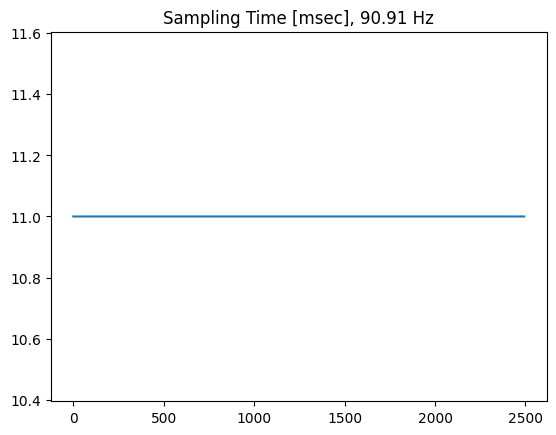

In [5]:
plt.plot(diff)
plt.title(f"Sampling Time [msec], {1000/np.mean(diff):.2f} Hz");

In [6]:
accel = [(i.ax,i.ay,i.az) for i in imu]
accel = np.array(accel)
print(f"Accel std: {np.std(accel)}")

gyro = [(i.gx,i.gy,i.gz) for i in imu]
gyro = np.array(gyro)
print(f"Gyro std: {np.std(gyro)}")

altitude = np.array([i.altitude for i in imu])#-imu[0].altitude
print(f"Bar std: {np.std(altitude)}")

Accel std: 0.4684290661587454
Gyro std: 0.0163232282527541
Bar std: 0.06371430139902115


Text(0, 0.5, 'Altitude [m]')

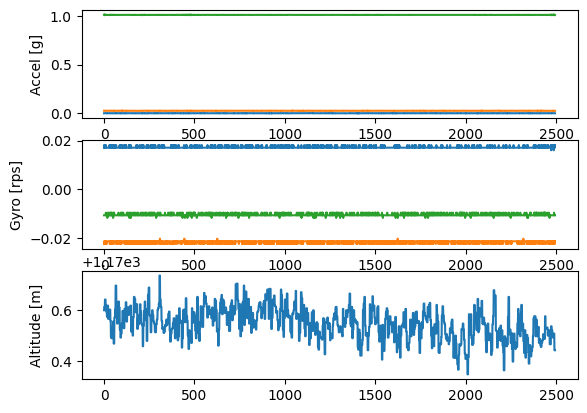

In [8]:
plt.subplot(3,1,1);plt.plot(accel);plt.ylabel("Accel [g]")
plt.subplot(3,1,2);plt.plot(gyro);plt.ylabel("Gyro [rps]")
plt.subplot(3,1,3);plt.plot(altitude[:]);plt.ylabel("Altitude [m]")

0.06371430139902115
0.004059512202765309


Text(0.5, 1.0, '1170.600341796875')

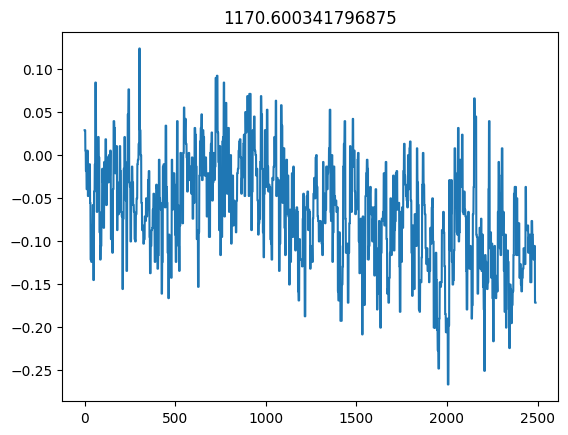

In [9]:
print(np.std(altitude))
print(np.var(altitude))
plt.plot(altitude[5:]-altitude[4])
plt.title(f"{altitude[0]}")

In [62]:
from spiceweasel import EKF

mag_inclination = 61.03138 *np.pi / 180.0 # rads
Bned = np.array([
    23051.0, # N
    3209.7,  # E
    42040.7  # D
]) # nT, Albaquerque NM

def func(dt, x, u):
    """
    state:  X = [x,y,z,dx,dy,dz,qw,qx,qy,qz]
    inputs: u = [ax,ay,az, wx,wy,wz]
    
    dt: time step
    x: state estimate
    u: control forces or other inputs
    """
    q = Quaternion(*u[6:10])
    # q = Quaternion(*x[6:10])
    # qd = 0.5 * q * Quaternion(0,*u[3:6])
    # print(qd)
    # print(x)
    # gb = q.conjugate * Quaternion(0,0,0,1.0) * q # grav in body frame
    # a = 9.81*(u[:3] - np.array(gb[1:]))
    
    # rotate accel to nav frame from body, remove gravity
    ag = q * Quaternion(0,*(u[:3]-x[6:9])) * q.conjugate
    a = 9.8*(np.array(ag[1:]) - np.array([0,0,1.0]))
    
    anoise = u[10:]

    xx = [
        x[3], # dpos_nav = vel_nav
        x[4],
        x[5],
        a[0], # dvel_nav = R_nav * accel_body
        a[1],
        a[2],
        # qd.w,
        # qd.x,
        # qd.y,
        # qd.z
        anoise[0], # est accel bias
        anoise[1],
        anoise[2]
    ]
    # print(xx)
    xx = np.array(xx)
    # print(xx)
    return xx

# create a kalman filter
state_size = 9 #6 #10
meas_size = 3
dt = 0.011
ekf = EKF(func, dt, state_size, meas_size)

# so reset puts R and Q to identify matrix, you should
# adjust them to your system
ekf.reset()
ekf.R *= 0.25 # measurement cov
ekf.Q *= .5   # process cov
# ekf.H = np.eye(meas_size,state_size) # only measuring position
ekf.H = np.zeros((meas_size,state_size)); ekf.H[2,2] = 1 # only altitude is measured

# initialize state, default sets this to zeros
ekf.x = np.array([
    0,0,imu[0].altitude,
    0,0,0,
    # 1,0,0,0
    0,0,0
])

savey = []

# Accel bias noise est
an = np.random.normal(0,0.005,(len(imu),3))
# an = np.zeros((len(imu),3))

# main filtering loop
for i,(im, alt) in enumerate(zip(imu, altitude)):
    u = np.array([
        im.ax,im.ay,im.az,
        im.gx,im.gy,im.gz,
        im.qw,im.qx,im.qy,im.qz,
        an[i,0], an[i,1], an[i,2]
    ])
    ekf.predict(u)
    meas = np.array(([0,0,alt]))
    y = ekf.update(meas)
    savey.append(y)
    
yy = np.array(savey)

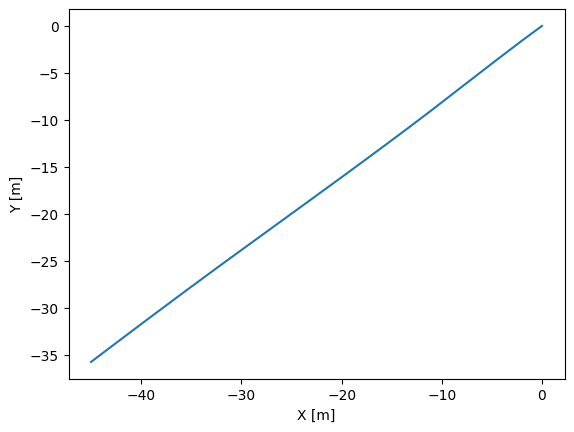

In [63]:
plt.plot(yy[:,0], yy[:,1]);
# plt.title("X vs Y ");
plt.ylabel("Y [m]")
plt.xlabel("X [m]");

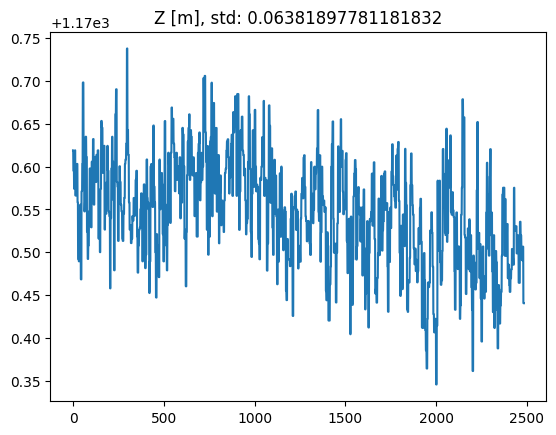

In [35]:
s = 10
plt.plot(yy[s:,2]);
plt.title(f"Z [m], std: {np.std(yy[s:,2])}");

In [13]:
# euler = np.array([Quaternion(*y[6:10]).to_euler(degrees=True) for y in yy])
# plt.plot(euler)
# plt.title("Euler Angles [degrees]");

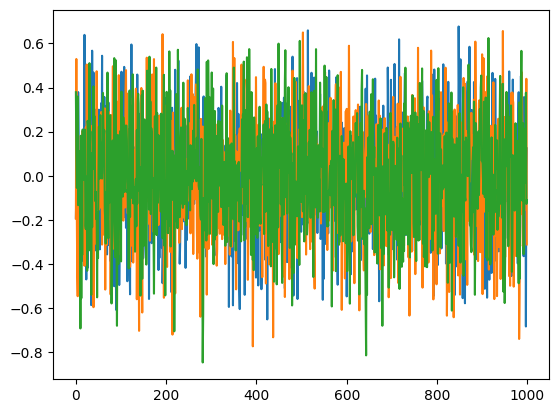

In [17]:
d = np.random.normal(0,0.25,(1000,3))
plt.plot(d);

In [275]:
d

-0.2758699336902496